# 1. Exploration et compréhension

Ce notebook se concentre sur le chargement, l'exploration et le nettoyage des données du marché CAC40. Nous optimiserons l'utilisation de la mémoire, traiterons les problèmes de qualité des données et préparerons des ensembles de données propres pour une analyse plus approfondie.

## Fichiers de données
- `cac40.csv`: Valeurs du cac40 du 02/01/2023 au 01/01/2025 (Open, High, Close, Low, Volume)
- `sto.parquet`: EURO 


In [10]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


print("Libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")


Libraries imported successfully!
Pandas version: 2.3.2
NumPy version: 2.2.6


## 1. Importation et inspection

Commençons par charger les deux ensembles de données et examinons leur structure et leur qualité.


In [11]:
# Load CAC40 main dataset
print("Loading CAC40 main dataset...")
cac40_df = pd.read_csv('cac40.csv')

# Clean column names (remove extra spaces)
cac40_df.columns = cac40_df.columns.str.strip()
print(f"CAC40 dataset: {cac40_df.shape[0]} rows, {cac40_df.shape[1]} columns")
print(f"Memory usage: {cac40_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print("\nFirst 5 rows:")
print(cac40_df.head())
print("\nData types:")
print(cac40_df.dtypes)
print("\nBasic info:")
print(cac40_df.info())


Loading CAC40 main dataset...
CAC40 dataset: 533 rows, 7 columns
Memory usage: 0.20 MB

First 5 rows:
          Date   Index      Open       High       Low      Close    Volume
0  2023-07-10   CAC40    990.15   997.11     988.11    988.56     123386.0
1  2023-01-20   CAC40    999.39   1003.24    999.08    998.35     163972.0
2  2023-04-03   CAC40    991.58   992.67     989.91    989.29     867344.0
3  2024-04-26   CAC40             1006.47    1001.66   1003.24    792459.0
4  2024-04-19   CAC40   1007.91   1009.4     1001.94   1002.77    943556.0

Data types:
Date       object
Index      object
Open       object
High       object
Low        object
Close      object
Volume    float64
dtype: object

Basic info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 533 entries, 0 to 532
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    533 non-null    object 
 1   Index   533 non-null    object 
 2   Open    533 non-null    o

In [12]:
# Load EURO STOXX 50 dataset
print("Loading EURO STOXX 50 dataset...")
try:
    sto_df = pd.read_parquet('sto.parquet')
    print(f"STO dataset: {sto_df.shape[0]} rows, {sto_df.shape[1]} columns")
    print(f"Memory usage: {sto_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    print("\nFirst 5 rows:")
    print(sto_df.head())
    print("\nData types:")
    print(sto_df.dtypes)
    print("\nUnique values in each column:")
    for col in sto_df.columns:
        print(f"{col}: {sto_df[col].nunique()} unique values")
except Exception as e:
    print(f"Error loading parquet file: {e}")
    sto_df = None


Loading EURO STOXX 50 dataset...
STO dataset: 700 rows, 6 columns
Memory usage: 0.24 MB

First 5 rows:
      Date              Close               High                Low  \
0      NaN          ^STOXX50E          ^STOXX50E          ^STOXX50E   
1  19360.0    3882.2900390625    3921.3701171875  3852.070068359375   
2  19361.0  3973.969970703125             3975.5    3891.0400390625   
3  19362.0   3959.47998046875  3974.610107421875     3950.419921875   
4  19363.0     4017.830078125   4017.85009765625  3951.929931640625   

                Open     Volume  
0          ^STOXX50E  ^STOXX50E  
1  3852.070068359375   33158800  
2    3891.0400390625   39907300  
3  3967.010009765625   26926500  
4    3959.9599609375   28231800  

Data types:
Date      float64
Close      object
High       object
Low        object
Open       object
Volume     object
dtype: object

Unique values in each column:
Date: 699 unique values
Close: 697 unique values
High: 697 unique values
Low: 700 unique values
Open

## 2. Nettoyage et mise en forme

### Cohérence temporelle

In [13]:
# Temporal consistency verification for financial data
print("=== TEMPORAL CONSISTENCY VERIFICATION ===")

def check_temporal_consistency(df, date_column='Date', dataset_name="Dataset"):
    """
    Verifies temporal consistency of a financial dataset.
    Expects 5 consecutive trading days followed by 2 weekend days.
    """
    print(f"\n--- Analysis of {dataset_name} ---")
    
    # Convert to datetime if necessary
    if not pd.api.types.is_datetime64_any_dtype(df[date_column]):
        df[date_column] = pd.to_datetime(df[date_column])
    
    # Sort by date
    df_sorted = df.sort_values(date_column).reset_index(drop=True)
    
    # Check for duplicate dates
    duplicate_dates = df_sorted[df_sorted[date_column].duplicated()]
    if len(duplicate_dates) > 0:
        print(f"⚠️  {len(duplicate_dates)} duplicate dates found:")
        print(duplicate_dates[date_column].tolist())
    else:
        print("✅ No duplicate dates")
    
    # Create complete date series for the period
    start_date = df_sorted[date_column].min()
    end_date = df_sorted[date_column].max()
    
    # Generate all dates in the period
    all_dates = pd.date_range(start=start_date, end=end_date, freq='D')
    
    # Identify weekdays (0=Monday, 6=Sunday)
    weekdays = all_dates.weekday
    
    # Create expected date series (Monday to Friday only)
    expected_trading_days = all_dates[weekdays < 5]  # 0-4 = Monday to Friday
    
    # Dates present in the dataset
    actual_dates = set(df_sorted[date_column].dt.date)
    expected_dates = set(expected_trading_days.date)
    
    # Find missing dates
    missing_dates = expected_dates - actual_dates
    # Find extra dates (weekends or holidays)
    extra_dates = actual_dates - expected_dates
    
    print(f"\n📅 Period analyzed: {start_date.date()} to {end_date.date()}")
    print(f"📊 Total days in period: {len(all_dates)}")
    print(f"📈 Expected trading days: {len(expected_trading_days)}")
    print(f"📉 Present trading days: {len(actual_dates)}")
    
    # Analyze gaps in data
    if missing_dates:
        print(f"\n❌ {len(missing_dates)} missing trading days:")
        missing_dates_sorted = sorted(list(missing_dates))
        
        # Group consecutive missing dates
        gaps = []
        current_gap = [missing_dates_sorted[0]]
        
        for i in range(1, len(missing_dates_sorted)):
            if (missing_dates_sorted[i] - missing_dates_sorted[i-1]).days == 1:
                current_gap.append(missing_dates_sorted[i])
            else:
                gaps.append(current_gap)
                current_gap = [missing_dates_sorted[i]]
        gaps.append(current_gap)
        
        for gap in gaps:
            if len(gap) == 1:
                print(f"  - {gap[0]} (isolated day)")
            else:
                print(f"  - {gap[0]} to {gap[-1]} ({len(gap)} consecutive days)")
    else:
        print("✅ No missing trading days")
    
    # Analyze extra dates
    if extra_dates:
        print(f"\n⚠️  {len(extra_dates)} extra dates (probably weekends or holidays):")
        extra_dates_sorted = sorted(list(extra_dates))
        for date in extra_dates_sorted[:10]:  # Show only first 10
            weekday_name = pd.to_datetime(date).strftime('%A')
            print(f"  - {date} ({weekday_name})")
        if len(extra_dates) > 10:
            print(f"  ... and {len(extra_dates) - 10} others")
    
    # Check regularity of patterns
    print(f"\n🔍 Temporal pattern analysis:")
    
    # Calculate intervals between dates
    date_diffs = df_sorted[date_column].diff().dropna()
    
    # Analyze intervals
    unique_intervals = date_diffs.value_counts().sort_index()
    print("Intervals between dates:")
    for interval, count in unique_intervals.head(10).items():
        print(f"  - {interval.days} days: {count} occurrences")
    
    # Check for 5 days + 2 days patterns
    weekend_patterns = 0
    
    # Check if we have enough data for analysis
    if len(df_sorted) >= 8:  # At least 8 rows to analyze 7 consecutive days
        for i in range(len(df_sorted) - 7):  # Changed from -6 to -7 to avoid index error
            try:
                current_date = df_sorted.iloc[i][date_column]
                next_5_days = [df_sorted.iloc[i+j][date_column] for j in range(1, 6)]
                next_7_days = [df_sorted.iloc[i+j][date_column] for j in range(1, 8)]
                
                # Check if next 5 days are consecutive
                consecutive_5 = all((next_5_days[j] - next_5_days[j-1]).days == 1 for j in range(1, 5))
                
                # Check if there's a 2-day gap after the 5 days
                if consecutive_5 and len(next_7_days) == 7:
                    gap_after_5 = (next_7_days[5] - next_5_days[-1]).days
                    if gap_after_5 == 3:  # 2 weekend days + 1 trading day
                        weekend_patterns += 1
            except (IndexError, KeyError):
                # Ignore cases where we exceed DataFrame limits
                continue
    else:
        print("⚠️  Not enough data to analyze weekend patterns")
    
    print(f"5 days + weekend patterns detected: {weekend_patterns}")
    
    # Consistency score
    total_expected = len(expected_trading_days)
    total_actual = len(actual_dates)
    missing_count = len(missing_dates)
    extra_count = len(extra_dates)
    
    consistency_score = max(0, 100 - (missing_count + extra_count) * 2)
    
    print(f"\n📊 Temporal consistency score: {consistency_score}/100")
    
    if consistency_score >= 90:
        print("✅ Excellent - Very consistent data")
    elif consistency_score >= 70:
        print("⚠️  Good - Minor inconsistencies")
    else:
        print("❌ Problematic - Many inconsistencies detected")
    
    return {
        'missing_dates': missing_dates,
        'extra_dates': extra_dates,
        'consistency_score': consistency_score,
        'total_expected': total_expected,
        'total_actual': total_actual
    }

print("Temporal verification script created successfully!")


=== TEMPORAL CONSISTENCY VERIFICATION ===
Temporal verification script created successfully!


In [14]:
# Apply temporal verification to CAC40 data
print("=== APPLYING TEMPORAL VERIFICATION ===")

# Load original CSV file directly
try:
    # Load original CSV file
    cac40_df = pd.read_csv('cac40.csv')
    # Clean column names
    cac40_df.columns = cac40_df.columns.str.strip()
    print("✅ cac40.csv file loaded successfully")
    dataset_source = "CAC40 Original"
except FileNotFoundError:
    print("❌ cac40.csv file not found")
    print("Please ensure the cac40.csv file is in the current directory")

# Check that Date column exists and DataFrame is not empty
if 'Date' not in cac40_df.columns:
    print("❌ 'Date' column not found in dataset")
    print(f"Available columns: {list(cac40_df.columns)}")
elif len(cac40_df) == 0:
    print("❌ Dataset is empty")
else:
    print(f"✅ Dataset loaded successfully: {len(cac40_df)} rows")
    print(f"Columns: {list(cac40_df.columns)}")
    
    # Apply temporal verification
    try:
        temporal_results = check_temporal_consistency(
            cac40_df, 
            date_column='Date', 
            dataset_name=f"{dataset_source} - CAC40"
        )
        
        # Display summary
        print(f"\n📋 VERIFICATION SUMMARY:")
        print(f"Source: {dataset_source}")
        print(f"Consistency score: {temporal_results['consistency_score']}/100")
        print(f"Expected days: {temporal_results['total_expected']}")
        print(f"Present days: {temporal_results['total_actual']}")
        print(f"Missing days: {len(temporal_results['missing_dates'])}")
        print(f"Extra days: {len(temporal_results['extra_dates'])}")
        
    except Exception as e:
        print(f"❌ Error during temporal verification: {str(e)}")
        print("Check that data is in the correct format")


=== APPLYING TEMPORAL VERIFICATION ===
✅ cac40.csv file loaded successfully
✅ Dataset loaded successfully: 533 rows
Columns: ['Date', 'Index', 'Open', 'High', 'Low', 'Close', 'Volume']

--- Analysis of CAC40 Original - CAC40 ---
⚠️  10 duplicate dates found:
[Timestamp('2023-04-18 00:00:00'), Timestamp('2023-05-12 00:00:00'), Timestamp('2023-06-27 00:00:00'), Timestamp('2023-11-06 00:00:00'), Timestamp('2024-04-05 00:00:00'), Timestamp('2024-04-12 00:00:00'), Timestamp('2024-07-23 00:00:00'), Timestamp('2024-10-31 00:00:00'), Timestamp('2024-11-08 00:00:00'), Timestamp('2024-12-02 00:00:00')]

📅 Period analyzed: 2023-01-02 to 2025-01-01
📊 Total days in period: 731
📈 Expected trading days: 523
📉 Present trading days: 523
✅ No missing trading days

🔍 Temporal pattern analysis:
Intervals between dates:
  - 0 days: 10 occurrences
  - 1 days: 418 occurrences
  - 3 days: 104 occurrences
5 days + weekend patterns detected: 95

📊 Temporal consistency score: 100/100
✅ Excellent - Very consisten

### Valeurs manquantes

In [15]:
# Check for missing values in CAC40 main dataset
print("=== CAC40 Main Dataset Quality Issues ===")
print("Column names:", list(cac40_df.columns))


numeric_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
# Convert numeric columns to proper types for analysis
print("\nConverting numeric columns to proper types...")
for col in numeric_columns:
    if col in cac40_df.columns:
        # First, check for Euro symbols and other currency symbols
        euro_count = cac40_df[col].astype(str).str.contains('€', na=False).sum()
        if euro_count > 0:
            print(f"  Found {euro_count} values with € symbol in {col}")
            # Show examples of values with Euro symbols
            euro_values = cac40_df[cac40_df[col].astype(str).str.contains('€', na=False)]
            print(f"  Examples: {euro_values[col].head().tolist()}")
        
        # Remove Euro symbols and other currency symbols, then convert to numeric
        cac40_df[col] = cac40_df[col].astype(str).str.replace('€', '', regex=False)
        cac40_df[col] = cac40_df[col].astype(str).str.replace('$', '', regex=False)
        cac40_df[col] = cac40_df[col].astype(str).str.replace('£', '', regex=False)
        cac40_df[col] = cac40_df[col].astype(str).str.replace(',', '', regex=False)  # Remove commas
        cac40_df[col] = cac40_df[col].astype(str).str.replace(' ', '', regex=False)  # Remove spaces
        
        # Convert to numeric
        cac40_df[col] = pd.to_numeric(cac40_df[col], errors='coerce')

# Now check for missing values after conversion and show complete rows
print("\nMissing values after type conversion:")
print(cac40_df.isnull().sum())
print(f"\nTotal missing values: {cac40_df.isnull().sum().sum()}")

# Show complete rows with any missing values
print("\nComplete rows with missing values:")
missing_rows = cac40_df[cac40_df.isnull().any(axis=1)]
if len(missing_rows) > 0:
    print(missing_rows.to_string(index=True))
else:
    print("No rows with missing values found.")

=== CAC40 Main Dataset Quality Issues ===
Column names: ['Date', 'Index', 'Open', 'High', 'Low', 'Close', 'Volume']

Converting numeric columns to proper types...
  Found 6 values with € symbol in High
  Examples: ['994.83€  ', '1005.44€ ', '996.39€  ', '992.02€  ', '990.79€  ']
  Found 1 values with € symbol in Low
  Examples: ['999.14€ ']

Missing values after type conversion:
Date       0
Index      0
Open       6
High       7
Low        3
Close      4
Volume    10
dtype: int64

Total missing values: 30

Complete rows with missing values:
          Date   Index     Open     High      Low    Close    Volume
3   2024-04-26  CAC40       NaN  1006.47  1001.66  1003.24  792459.0
8   2024-05-08  CAC40   1006.18  1012.18  1002.44  1001.58       NaN
37  2024-06-28  CAC40   1007.94  1009.35      NaN  1010.88  277597.0
54  2023-05-26  CAC40    986.22   991.18   981.61   987.32       NaN
63  2023-12-18  CAC40   1000.08      NaN   995.14   999.12  759987.0
73  2024-05-02  CAC40    998.56  1000.

---

### Doublons

In [16]:
# Detect duplicates in the CAC40 dataset
print("=== Duplicate Detection ===")

# Check for complete duplicates (all identical columns)
complete_duplicates = cac40_df.duplicated()
print(f"Number of completely duplicated rows: {complete_duplicates.sum()}")

if complete_duplicates.sum() > 0:
    print("\nCompletely duplicated rows:")
    duplicate_rows = cac40_df[complete_duplicates]
    print(duplicate_rows.to_string(index=True))

# Check for date-based duplicates (more relevant for financial data)
# Only count date duplicates that are NOT complete duplicates
date_duplicates = cac40_df.duplicated(subset=['Date'])
date_only_duplicates = date_duplicates & ~complete_duplicates
print(f"\nNumber of date-based duplicates (excluding complete duplicates): {date_only_duplicates.sum()}")

if date_only_duplicates.sum() > 0:
    print("\nRows with duplicated dates (but not complete duplicates):")
    date_duplicate_rows = cac40_df[date_only_duplicates]
    print(date_duplicate_rows.to_string(index=True))
    
    # Show all rows for each duplicated date (excluding complete duplicates)
    print("\nAll rows for duplicated dates (excluding complete duplicates):")
    duplicate_dates = cac40_df[cac40_df.duplicated(subset=['Date'], keep=False)]
    # Filter out complete duplicates
    duplicate_dates_filtered = duplicate_dates[~duplicate_dates.index.isin(cac40_df[complete_duplicates].index)]
    duplicate_dates_sorted = duplicate_dates_filtered.sort_values('Date')
    print(duplicate_dates_sorted.to_string(index=True))


# Duplicate summary
print(f"\n=== Duplicate Summary ===")
print(f"Total rows: {len(cac40_df)}")
print(f"Complete duplicates: {complete_duplicates.sum()}")
print(f"Date duplicates (excluding complete duplicates): {date_only_duplicates.sum()}")
print(f"Total unique duplicate issues: {complete_duplicates.sum() + date_only_duplicates.sum()}")

=== Duplicate Detection ===
Number of completely duplicated rows: 10

Completely duplicated rows:
          Date   Index     Open     High      Low    Close    Volume
83  2023-11-06  CAC40   1002.69  1003.25   995.99  1003.10  965256.0
169 2024-11-08  CAC40   1006.01  1006.71  1004.49  1007.66  256877.0
229 2024-04-05  CAC40   1005.52  1006.56  1002.71  1009.13  585651.0
264 2024-12-02  CAC40   1008.63  1013.62  1004.00  1004.26  978878.0
333 2024-04-12  CAC40   1007.20  1010.59  1005.35  1007.40  590399.0
351 2024-07-23  CAC40   1005.85  1007.06  1003.91  1007.56  395599.0
353 2024-10-31  CAC40   1008.71  1010.57  1008.66  1006.94  623260.0
386 2023-05-12  CAC40    992.20   993.69   989.16      NaN  915495.0
437 2023-06-27  CAC40    993.56   994.08   983.87   996.37  586675.0
527 2023-04-18  CAC40    993.04   996.24   990.90   991.82  137019.0

Number of date-based duplicates (excluding complete duplicates): 0

=== Duplicate Summary ===
Total rows: 533
Complete duplicates: 10
Date dup

---

### Valeurs négatives

In [17]:

# Check for negative values in the dataset
print("\n=== Negative Values Detection ===")

# Check for negative values in price columns (should never be negative)
price_columns = ['Open', 'High', 'Low', 'Close']
print("Checking for negative values in price columns:")
for col in price_columns:
    if col in cac40_df.columns:
        negative_count = (cac40_df[col] < 0).sum()
        print(f"{col}: {negative_count} negative values")
        if negative_count > 0:
            print(f"  Examples of negative {col} values:")
            negative_prices = cac40_df[cac40_df[col] < 0]
            available_cols = [col for col in ['Date', col] if col in negative_prices.columns]
            if available_cols:
                print(negative_prices[available_cols].head())

# Check for negative volumes
print(f"\nChecking for negative volumes:")
negative_volumes = cac40_df[cac40_df['Volume'] < 0]
print(f"Negative volumes: {len(negative_volumes)} rows")
if len(negative_volumes) > 0:
    print("Examples of negative volumes:")
    available_cols = [col for col in ['Date', 'Volume'] if col in negative_volumes.columns]
    if available_cols:
        print(negative_volumes[available_cols].head())

# Summary of negative values
total_negative_prices = sum((cac40_df[col] < 0).sum() for col in price_columns if col in cac40_df.columns)
total_negative_volumes = (cac40_df['Volume'] < 0).sum()

print(f"\n=== Negative Values Summary ===")
print(f"Total negative price values: {total_negative_prices}")
print(f"Total negative volume values: {total_negative_volumes}")
print(f"Total negative values: {total_negative_prices + total_negative_volumes}")


=== Negative Values Detection ===
Checking for negative values in price columns:
Open: 0 negative values
High: 0 negative values
Low: 0 negative values
Close: 1 negative values
  Examples of negative Close values:
          Date    Close
213 2023-10-31 -5010.15

Checking for negative volumes:
Negative volumes: 5 rows
Examples of negative volumes:
          Date    Volume
10  2023-12-20 -299298.0
88  2023-07-19 -998035.0
92  2024-01-16 -123559.0
154 2024-10-18 -437629.0
415 2023-07-25 -301202.0

=== Negative Values Summary ===
Total negative price values: 1
Total negative volume values: 5
Total negative values: 6


---

#### Optimisations et suppressions

In [18]:
# Clean CAC40 main dataset
print("=== Cleaning CAC40 Main Dataset ===")

# Store original memory usage
original_memory = cac40_df.memory_usage(deep=True).sum() / 1024**2
print(f"Original memory usage: {original_memory:.2f} MB")

# Convert Date to datetime
cac40_df['Date'] = pd.to_datetime(cac40_df['Date'])

# Delete rows with missing values in critical columns
print("Removing rows with missing values...")
initial_rows = len(cac40_df)
cac40_df = cac40_df.dropna(subset=['Open', 'High', 'Low', 'Close', 'Volume'])
rows_after_missing = len(cac40_df)
print(f"Removed {initial_rows - rows_after_missing} rows with missing values")

# Delete rows with negative values in price columns (should never be negative)
print("Removing rows with negative price values...")
price_columns = ['Open', 'High', 'Low', 'Close']
for col in price_columns:
    negative_count = (cac40_df[col] < 0).sum()
    if negative_count > 0:
        print(f"  Removing {negative_count} rows with negative {col} values")
        cac40_df = cac40_df[cac40_df[col] >= 0]

# Delete rows with negative volumes
print("Removing rows with negative volumes...")
negative_volumes = (cac40_df['Volume'] < 0).sum()
if negative_volumes > 0:
    print(f"  Removing {negative_volumes} rows with negative volumes")
    cac40_df = cac40_df[cac40_df['Volume'] >= 0]

final_rows = len(cac40_df)
print(f"Total rows removed: {initial_rows - final_rows}")
print(f"Final dataset: {final_rows} rows")


# Optimize data types for memory efficiency
# Delete Index column as it always has the same value
cac40_df = cac40_df.drop('Index', axis=1)
print(f"Index column deleted. New shape: {cac40_df.shape}")
cac40_df['Open'] = cac40_df['Open'].astype('float32')
cac40_df['High'] = cac40_df['High'].astype('float32')
cac40_df['Low'] = cac40_df['Low'].astype('float32')
cac40_df['Close'] = cac40_df['Close'].astype('float32')
cac40_df['Volume'] = cac40_df['Volume'].astype('float32')

# Sort by date
cac40_df = cac40_df.sort_values('Date').reset_index(drop=True)

# Remove duplicates
cac40_df = cac40_df.drop_duplicates().reset_index(drop=True)

new_memory = cac40_df.memory_usage(deep=True).sum() / 1024**2
print(f"New memory usage: {new_memory:.2f} MB")
print(f"Memory reduction: {((original_memory - new_memory) / original_memory * 100):.1f}%")
print(f"Final dataset: {cac40_df.shape[0]} rows, {cac40_df.shape[1]} columns")
print(f"Date range: {cac40_df['Date'].min()} to {cac40_df['Date'].max()}")


=== Cleaning CAC40 Main Dataset ===
Original memory usage: 0.06 MB
Removing rows with missing values...
Removed 30 rows with missing values
Removing rows with negative price values...
  Removing 1 rows with negative Close values
Removing rows with negative volumes...
  Removing 5 rows with negative volumes
Total rows removed: 36
Final dataset: 497 rows
Index column deleted. New shape: (497, 6)
New memory usage: 0.01 MB
Memory reduction: 76.7%
Final dataset: 488 rows, 6 columns
Date range: 2023-01-02 00:00:00 to 2025-01-01 00:00:00


## 3. Analyse visuelle de base via graphiques (Matplotlib)


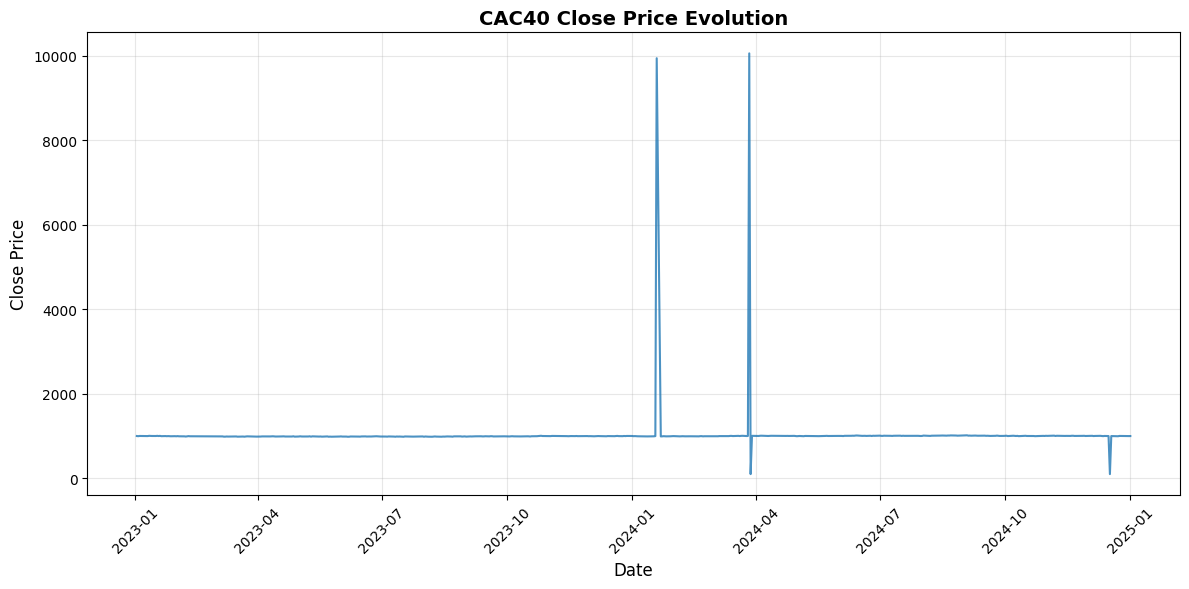

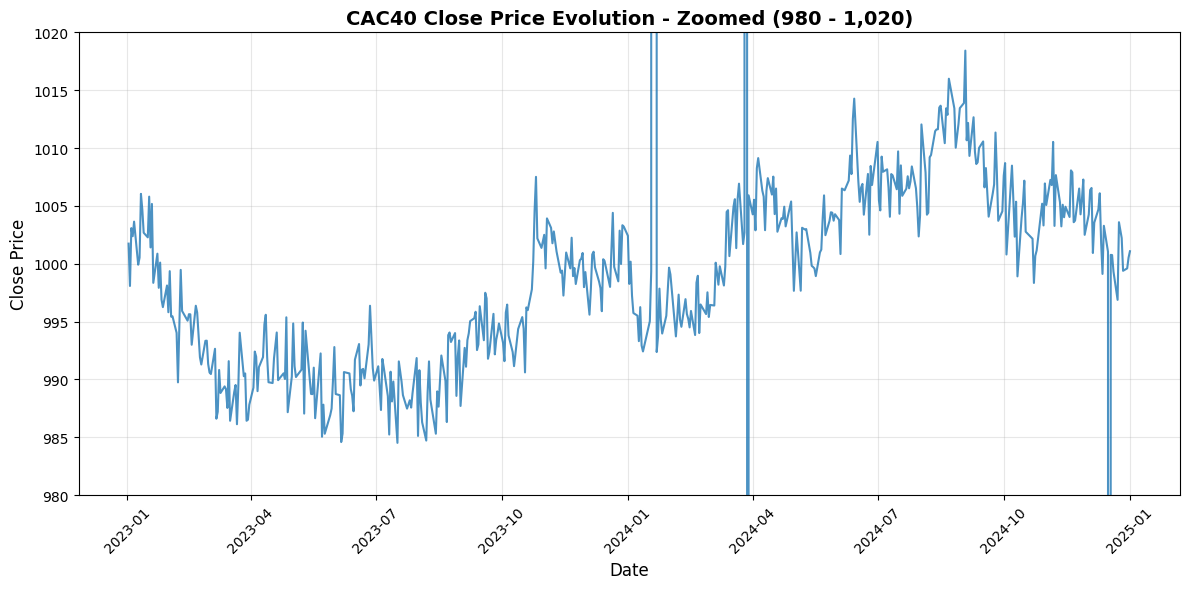

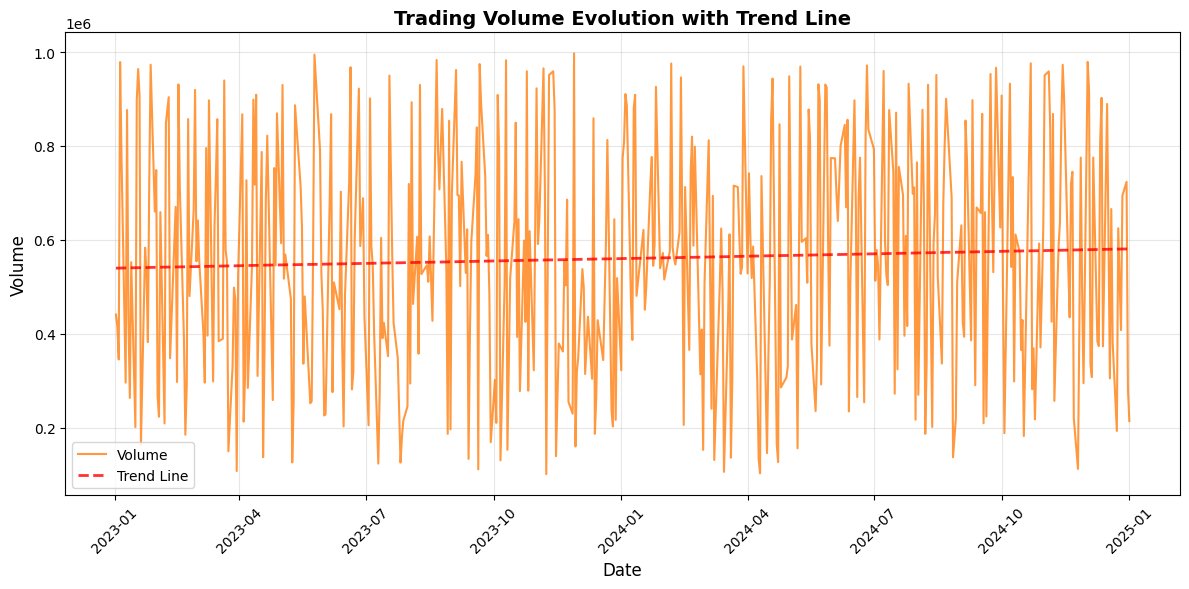

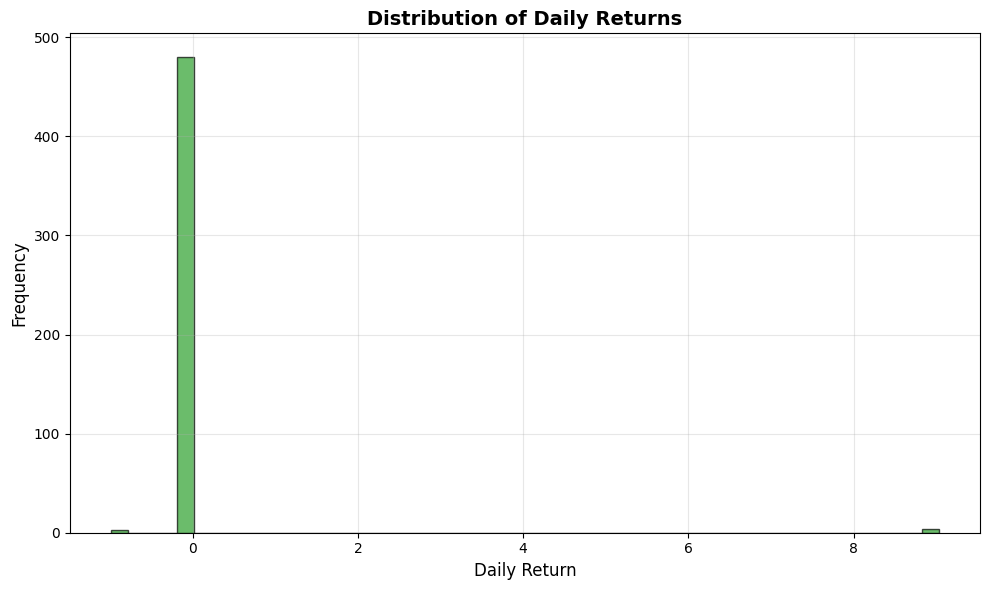

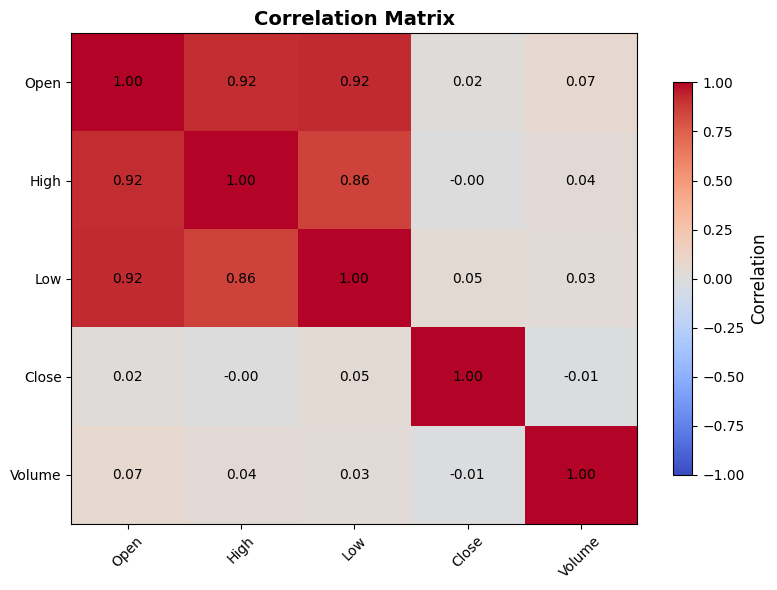


=== Basic Statistics ===
Date range: 2023-01-02 to 2025-01-01
Total trading days: 488
Average daily return: 0.0682
Daily return volatility (std): 0.8166
Min daily return: -0.9900
Max daily return: 9.0304


In [19]:
# Set up the plotting style
plt.style.use('default')
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# 1. Close price evolution over time 
plt.figure(figsize=(12, 6))
plt.plot(cac40_df['Date'], cac40_df['Close'], linewidth=1.5, alpha=0.8, color=colors[0])
plt.title('CAC40 Close Price Evolution', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 1b. Close price evolution - ZOOMED VERSION (980 - 1,020)
plt.figure(figsize=(12, 6))
plt.plot(cac40_df['Date'], cac40_df['Close'], linewidth=1.5, alpha=0.8, color=colors[0])
plt.title('CAC40 Close Price Evolution - Zoomed (980 - 1,020)', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price', fontsize=12)
plt.ylim(980, 1020)  # Zoom between 980 and 1020
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 2. Volume over time with trend line
plt.figure(figsize=(12, 6))
plt.plot(cac40_df['Date'], cac40_df['Volume'], linewidth=1.5, alpha=0.8, color=colors[1], label='Volume')
plt.title('Trading Volume Evolution with Trend Line', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Volume', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Add trend line using manual linear regression (no sklearn needed)
import numpy as np

# Convert dates to numeric values for regression
date_numeric = np.arange(len(cac40_df))
volume_values = cac40_df['Volume'].values

# Manual linear regression calculation
n = len(date_numeric)
sum_x = np.sum(date_numeric)
sum_y = np.sum(volume_values)
sum_xy = np.sum(date_numeric * volume_values)
sum_x2 = np.sum(date_numeric ** 2)

# Calculate slope and intercept
slope = (n * sum_xy - sum_x * sum_y) / (n * sum_x2 - sum_x ** 2)
intercept = (sum_y - slope * sum_x) / n

# Calculate trend line
trend_line = slope * date_numeric + intercept

# Plot trend line
plt.plot(cac40_df['Date'], trend_line, '--', linewidth=2, color='red', alpha=0.8, label='Trend Line')

# Add legend
plt.legend()

plt.tight_layout()
plt.show()

# 3. Daily returns distribution
daily_returns = cac40_df['Close'].pct_change().dropna()
plt.figure(figsize=(10, 6))
plt.hist(daily_returns, bins=50, alpha=0.7, edgecolor='black', color=colors[2])
plt.title('Distribution of Daily Returns', fontsize=14, fontweight='bold')
plt.xlabel('Daily Return', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 4. Correlation heatmap
correlation_data = cac40_df[['Open', 'High', 'Low', 'Close', 'Volume']].corr()
plt.figure(figsize=(8, 6))
im = plt.imshow(correlation_data, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
plt.title('Correlation Matrix', fontsize=14, fontweight='bold')
plt.xticks(range(len(correlation_data.columns)), correlation_data.columns, rotation=45)
plt.yticks(range(len(correlation_data.columns)), correlation_data.columns)

# Add correlation values as text
for i in range(len(correlation_data.columns)):
    for j in range(len(correlation_data.columns)):
        text = plt.text(j, i, f'{correlation_data.iloc[i, j]:.2f}',
                        ha="center", va="center", color="black", fontsize=10)

# Add colorbar
cbar = plt.colorbar(im, shrink=0.8)
cbar.set_label('Correlation', fontsize=12)
plt.tight_layout()
plt.show()

# Print some basic statistics
print("\n=== Basic Statistics ===")
print(f"Date range: {cac40_df['Date'].min().strftime('%Y-%m-%d')} to {cac40_df['Date'].max().strftime('%Y-%m-%d')}")
print(f"Total trading days: {len(cac40_df)}")
print(f"Average daily return: {daily_returns.mean():.4f}")
print(f"Daily return volatility (std): {daily_returns.std():.4f}")
print(f"Min daily return: {daily_returns.min():.4f}")
print(f"Max daily return: {daily_returns.max():.4f}")



## 5. Export du dataset nettoyé


In [20]:
# Export cleaned datasets to parquet format for next notebooks
print("=== Exporting Cleaned Datasets ===")

# Ensure the Index column is removed before export
if 'Index' in cac40_df.columns:
    cac40_df = cac40_df.drop('Index', axis=1)
    print("Index column removed before export")

# Export CAC40 cleaned data
cac40_df.to_parquet('cac40_cleaned.parquet', index=False)
print(f"CAC40 cleaned data exported: {cac40_df.shape[0]} rows, {cac40_df.shape[1]} columns")


=== Exporting Cleaned Datasets ===
CAC40 cleaned data exported: 488 rows, 6 columns
